# Градиентный бустинг и кластеризация.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
from scipy.optimize import minimize
from sklearn.datasets import load_boston, make_moons
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
import warnings
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
warnings.filterwarnings('ignore')

## Градиентный бустинг своими руками

Реализуем алгоритм градиентного бустинга для регрессии.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Примем $\gamma_N = 1$ для каждого $N$. Реализуем нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмём MSE.

In [2]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1, fixed_gamma=0):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gammas = []
        self.fixed_gamma = fixed_gamma
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        y_new = np.zeros(y.shape)
        if self.fixed_gamma == 0:
            for i in range(self.n_estimators):
                y_new += self.learning_rate * self.find_best_gamma(y_new, x, y)
        else:
            for i in range(self.n_estimators):
                y_new += self.learning_rate * self._fit_predict_tree(x, y - y_new)

    def find_best_gamma(self, y_old, x, y_true):
        prediction = self._fit_predict_tree(x, y_true - y_old)
        gamma = minimize(lambda x: mean_squared_error(y_true - y_old, x * prediction), 0.5).x
        self.gammas.append(*gamma)
        return gamma * prediction
   
    def _fit_predict_tree(self, x, y):
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(x.shape[0])
        if self.fixed_gamma == 0:
            for i in range(self.n_estimators):
                y_pred += self.trees[i].predict(x) * self.gammas[i] * self.learning_rate
        else:
            for i in range(self.n_estimators):
                y_pred += self.trees[i].predict(x) * self.learning_rate
        return y_pred
    
    def get_info(self):
        return {"n_estimators":self.n_estimators, 
                "max_depth":self.max_depth, 
                "learning_rate":self.learning_rate,
                "fixed_gamma":self.fixed_gamma}
    
    def get_gammas(self):
        return self.gammas

Проверим реализацию на Boston dataset. Подберём оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага.

In [3]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [5]:
np.random.seed(19052019)
n = np.arange(5, 200, 5)
md = np.arange(4, 10, 1)
lr = np.arange(0.05, 1.01, 0.05)
best = np.inf
for i in tqdm(n):
    for j in md:
        for k in lr:
            gb = GradientBoosting(i, j, k, 0)
            gb.fit(X_train, y_train)
            mse = mean_squared_error(y_test, gb.predict(X_test))
            if mse < best:
                best = mse
                params = gb.get_info() #Модель ставить не стоит, потому что питон же будет и её обновлять (указатели)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [19:11<00:00, 29.53s/it]


In [6]:
print(params, "\n", best)

{'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.3, 'fixed_gamma': 0} 
 9.07223755821884


In [7]:
np.random.seed(19052019)
n = np.arange(5, 200, 5)
md = np.arange(4, 10, 1)
lr = np.arange(0.05, 1.01, 0.05)
best = np.inf
for i in tqdm(n):
    for j in md:
        for k in lr:
            gb = GradientBoosting(i, j, k, 1)
            gb.fit(X_train, y_train)
            mse = mean_squared_error(y_test, gb.predict(X_test))
            if mse < best:
                best = mse
                params = gb.get_info()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [09:32<00:00, 14.69s/it]


In [8]:
print(params, "\n", best)

{'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.3, 'fixed_gamma': 1} 
 9.129645870984007


## XGBoost. Прогнозирование задержки самолётов.

На основании доступных данных о рейсе нужно определить, будет ли он задержан на 15 минут.

In [9]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [10]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier(verbosity=0)
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.6957629249683959

In [12]:
train["DayOfWeek"] = train["DayOfWeek"].map(lambda x: "DOW" + x[-1])
train["Origin"] = train["Origin"].map(lambda x: "O" + x)
train["Dest"] = train["Dest"].map(lambda x: "D" + x)
train["DayofMonth"] = train["DayofMonth"].map(lambda x: "DM" + x)

for i in ["DayOfWeek", "UniqueCarrier", "Origin", "Dest", "Month", "DayofMonth"]:
    temp = pd.get_dummies(train[i])
    train = pd.concat([train, temp], axis=1)
    train = train.drop(i, axis = 1)

y_train = train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
train = train.drop("dep_delayed_15min", axis = 1)
X_train = train.values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

cat = CatBoostClassifier(silent=True, iterations=3500)
cat.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cat.predict_proba(X_valid)[:, 1])

0.7512377333066756

## DBSCAN своими руками

DBSCAN: Density-based spatial clustering of applications with noise

Реализуем класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [13]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.ms = min_samples

    def fit_predict(self, X):
        self.clusters = np.full(X.shape[0], None)
        n = 1
        self.dist = np.linalg.norm(np.tile(X, X.shape[0]).reshape(X.shape[0], X.shape[0], X.shape[1]) - X, axis = -1)
        for i in range(X.shape[0]):
            if self.clusters[i] == None:  
                self.grow_cluster(n, i)
                n += 1
        un, rc = np.unique(self.clusters, return_counts = True)
        for i in un[rc == 1]:
            self.clusters[self.clusters == i] = 0
        
        return self.clusters
    
    def grow_cluster(self, root, neighbours):
        self.clusters[neighbours] = root
        inmates = np.where([(self.dist[neighbours] < self.eps)])[1]
        if inmates.shape[0] >= self.ms:
            for i in inmates:   
                if self.clusters[i] == None:
                    self.grow_cluster(root, i)
        

Проверим себя на простом примере:

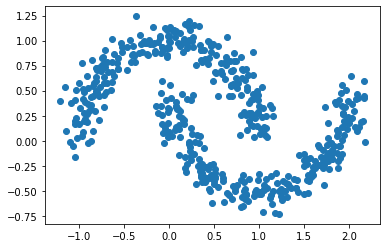

In [14]:
X, _ = make_moons(n_samples=500, noise=0.1, random_state=42)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуем это с помощью своей версии DBSCAN:

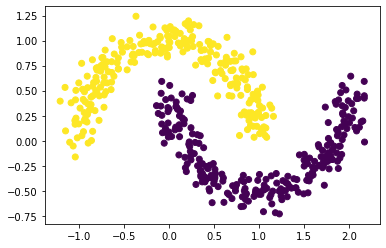

In [15]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Сравним полученный результат с результатом библиотечной реализации DBSCAN:

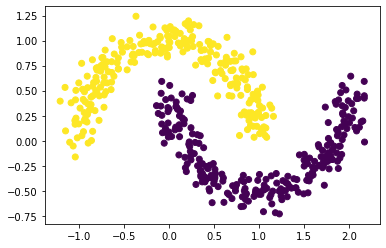

In [16]:
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()